In [1]:
%cd /mnt/hdd1/jkliu/Projects/ATGEmpirical/

/mnt/hdd1/jkliu/Projects/ATGEmpirical


/mnt/hdd1/jkliu/Projects/ATGEmpirical/venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
def calculate_precision_score(gt_transitions: list, tool_transitions: list):
    if len(gt_transitions) == 0:
        return 0
    if len(tool_transitions) == 0:
        return 0
    correct = 0
    for transition in tool_transitions:
        if transition in gt_transitions:
            correct += 1
    return correct / len(tool_transitions)

In [3]:
def calculate_recall_score(gt_transitions: list, tool_transitions: list):
    if len(gt_transitions) == 0:
        return 0
    if len(tool_transitions) == 0:
        return 0
    correct = 0
    for transition in tool_transitions:
        if transition in gt_transitions:
            correct += 1
    return correct / len(gt_transitions)

In [4]:
def calculate_f1_score(precision: float, recall: float):
    if precision == 0 or recall == 0:
        return 0
    return 2 * (precision * recall) / (precision + recall)

In [5]:
from result_plot.common import *
from core.apk_util import parse_manifest_file


def single_apk_evaluation(apk_path: str, real_transitions: dict):
    package_name, _, declared_activities, exported_activities = parse_manifest_file(apk_path)
    apk_name, tool_transitions = get_tool_result(apk_path, declared_activities)
    if tool_transitions is None:
        return
    if apk_name not in real_transitions:
        return
    real_transition = real_transitions[apk_name]
    precision_scores = {}
    recall_scores = {}
    f1_scores = {}
    tool_size = {}
    for tool in tools:
        if tool in tool_transitions:
            tool_transition = tool_transitions[tool]
            precision = calculate_precision_score(real_transition, tool_transition)
            recall = calculate_recall_score(real_transition, tool_transition)
            f1 = calculate_f1_score(precision, recall)
            precision_scores[tool] = precision
            recall_scores[tool] = recall
            f1_scores[tool] = f1
            tool_size[tool] = len(tool_transition)
    tool_size["real"] = len(real_transition)
    return apk_name, precision_scores, recall_scores, f1_scores, tool_size


Updated PATH: /usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin:/mnt/hdd1/jkliu/Applications/ncurses  # 你自己的 ncurses 目录/bin:/mnt/hdd1/jkliu/Applications/zsh/bin:/mnt/hdd1/jkliu/Applications/Android/cmdline-tools/latest/bin:/mnt/hdd1/jkliu/Applications/Android/emulator:/mnt/hdd1/jkliu/Applications/Android/platform-tools:/mnt/hdd1/jkliu/Applications/Android/tools:/mnt/hdd1/jkliu/Applications/Android/tools/bin:/mnt/hdd1/jkliu/Applications/Android/build-tools/35.0.0
/mnt/hdd1/jkliu/Applications/Android/build-tools/35.0.0/aapt
Successfully added aapt to PATH


In [6]:
def evaluate_all_apks(real_transitions: dict):
    all_apks = real_transitions.keys()
    results = {}
    all_precision_scores = {}
    all_recall_scores = {}
    all_f1_scores = {}
    all_tool_size = {}
    all_tool_size["real"] = []
    for apk in all_apks:
        result = single_apk_evaluation(apk, real_transitions)
        if result is not None:
            results[apk] = result[1:]
            for tool in tools:
                if tool in result[1]:
                    if tool not in all_precision_scores:
                        all_precision_scores[tool] = []
                    if tool not in all_recall_scores:
                        all_recall_scores[tool] = []
                    if tool not in all_f1_scores:
                        all_f1_scores[tool] = []
                    if tool not in all_tool_size:
                        all_tool_size[tool] = []
                    all_precision_scores[tool].append(result[1][tool])
                    all_recall_scores[tool].append(result[2][tool])
                    all_f1_scores[tool].append(result[3][tool])
                    all_tool_size[tool].append(result[4][tool])
            all_tool_size["real"].append(result[4]["real"])
    return results, all_precision_scores, all_recall_scores, all_f1_scores, all_tool_size

In [7]:
real_transitions = get_real_transitions()
set_current_version("first_round_no_internet")
results, all_precision_scores, all_recall_scores, all_f1_scores, all_tool_size = evaluate_all_apks(real_transitions)

extracting summaries for /mnt/hdd1/jkliu/Projects/ATGEmpirical/apks/fdroid/com.gpl.rpg.AndorsTrail_75.apk
extracting summaries for /mnt/hdd1/jkliu/Projects/ATGEmpirical/apks/fdroid/com.darkempire78.opencalculator_42.apk
extracting summaries for /mnt/hdd1/jkliu/Projects/ATGEmpirical/apks/fdroid/rocks.poopjournal.vacationdays_9.apk
extracting summaries for /mnt/hdd1/jkliu/Projects/ATGEmpirical/apks/fdroid/org.documentfoundation.libreoffice_38.apk
extracting summaries for /mnt/hdd1/jkliu/Projects/ATGEmpirical/apks/fdroid/org.xphnx.ameixamonochrome_4100.apk
extracting summaries for /mnt/hdd1/jkliu/Projects/ATGEmpirical/apks/fdroid/com.github.axet.audiorecorder_377.apk
extracting summaries for /mnt/hdd1/jkliu/Projects/ATGEmpirical/apks/fdroid/de.k3b.android.toGoZip_30.apk
extracting summaries for /mnt/hdd1/jkliu/Projects/ATGEmpirical/apks/fdroid/com.simplemobiletools.calculator_61.apk
extracting summaries for /mnt/hdd1/jkliu/Projects/ATGEmpirical/apks/fdroid/com.jarsilio.android.waveup_121.

In [8]:
real_transitions_list = []
for apk in real_transitions.keys():
    transitions = real_transitions[apk]
    for transition in transitions:
        real_transitions_list.append(transition)

In [9]:
def trunk_evaluation(real_transitions: dict):
    tool_all_transitions = {}
    all_tool_transitions = set()
    for apk in real_transitions.keys():
        package_name, _, declared_activities, exported_activities = parse_manifest_file(apk)
        apk_name, tool_transitions = get_tool_result(apk, declared_activities)
        if tool_transitions is None:
            continue
        if apk_name not in real_transitions:
            continue
        for tool in tools:
            if tool in tool_transitions:
                if tool not in tool_all_transitions:
                    tool_all_transitions[tool] = []
                tool_all_transitions[tool].extend(tool_transitions[tool])
    for tool in tools:
        all_tool_transitions.update(tool_all_transitions[tool])
        precision = calculate_precision_score(real_transitions_list, tool_all_transitions[tool])
        recall = calculate_recall_score(real_transitions_list, tool_all_transitions[tool])
        f1 = calculate_f1_score(precision, recall)
        print(f"{tool},{precision},{recall},{f1}")
    all_tool_transitions = list(all_tool_transitions)
    precision = calculate_precision_score(real_transitions_list, all_tool_transitions)
    recall = calculate_recall_score(real_transitions_list, all_tool_transitions)
    f1 = calculate_f1_score(precision, recall)
    print(f"all,{precision},{recall},{f1}")
        
trunk_evaluation(real_transitions)

extracting summaries for /mnt/hdd1/jkliu/Projects/ATGEmpirical/apks/fdroid/com.gpl.rpg.AndorsTrail_75.apk
extracting summaries for /mnt/hdd1/jkliu/Projects/ATGEmpirical/apks/fdroid/com.darkempire78.opencalculator_42.apk
extracting summaries for /mnt/hdd1/jkliu/Projects/ATGEmpirical/apks/fdroid/rocks.poopjournal.vacationdays_9.apk
extracting summaries for /mnt/hdd1/jkliu/Projects/ATGEmpirical/apks/fdroid/org.documentfoundation.libreoffice_38.apk
extracting summaries for /mnt/hdd1/jkliu/Projects/ATGEmpirical/apks/fdroid/org.xphnx.ameixamonochrome_4100.apk
extracting summaries for /mnt/hdd1/jkliu/Projects/ATGEmpirical/apks/fdroid/com.github.axet.audiorecorder_377.apk
extracting summaries for /mnt/hdd1/jkliu/Projects/ATGEmpirical/apks/fdroid/de.k3b.android.toGoZip_30.apk
extracting summaries for /mnt/hdd1/jkliu/Projects/ATGEmpirical/apks/fdroid/com.simplemobiletools.calculator_61.apk
extracting summaries for /mnt/hdd1/jkliu/Projects/ATGEmpirical/apks/fdroid/com.jarsilio.android.waveup_121.

In [10]:
import matplotlib.pyplot as plt


def violin_plot(result_dict: dict, file_name: str = None, log_scale: bool = True, show_prop: bool = False):
    print("Plotting violin plot")
    plt.rcParams["font.size"] = 12
    plt.rcParams["font.family"] = "sans-serif"
    plt.figure(figsize=(8, 10))
    tools = list(result_dict.keys())
    values = list(result_dict.values())
    plt.figure()
    # plt.violinplot(values, showmedians=True, showextrema=False)
    plt.violinplot(values, showmeans=True, showextrema=False)
    plt.xticks(range(1, len(tools) + 1), tools)
    if log_scale:
        plt.yscale('log')
    plt.xticks(rotation=45)
    if show_prop:
        plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
    if file_name is not None:
        if not os.path.exists("summary/figure"):
            os.makedirs("summary/figure")
        plt.savefig(f"summary/figure/{file_name}", bbox_inches='tight')
    plt.show()

In [11]:
from scipy.stats import mannwhitneyu
from effect_size_analysis import cliff_delta


def statistic_test(df: dict, exclude: list):
    print("Statistical test")
    for key1 in df.keys():
        if key1 in exclude:
            continue
        values1 = df[key1]
        for key2 in df.keys():
            if key2 in exclude:
                continue
            if key1 == key2:
                continue
            values2 = df[key2]
            res = mannwhitneyu(values1, values2)
            pvalue = res.pvalue
            if pvalue > 0.05:
                continue
            cliff = cliff_delta.cliff_delta(s1=values1, s2=values2, alpha=0.05, accurate_ci=True)
            delta = cliff[0]
            # if delta < 0.11 and delta > -0.11:
            #     continue
            print(f"{key1} vs {key2} {pvalue} {delta}")


In [12]:
import numpy as np


def statistic_values(df: dict):
    print("Statistical values")
    for key in df.keys():
        values = df[key]
        print(f"{key} {np.mean(values)} {np.median(values)} {np.max(values)} {np.min(values)} {np.std(values)}")


In [13]:
print(all_tool_size)
sum_tool_size = {}
for tool in all_tool_size:
    sum_tool_size[tool] = sum(all_tool_size[tool])

{'real': [30, 4, 6, 5, 4, 4, 1, 18, 6, 24, 4, 40, 46, 20, 6, 6, 4, 10, 2, 2, 3, 4, 8, 10, 11, 20, 4, 6, 16, 4, 13, 2, 20, 19, 4, 6, 4, 6, 6, 20, 6, 4, 2, 4, 4, 8, 42, 4, 8, 8, 2, 4, 6, 2, 16, 15, 2, 4, 6, 13, 22, 6, 9, 12, 30, 22, 7, 10, 14, 6, 20, 6, 6, 4, 4, 4, 6, 29, 16, 2, 8, 10, 6, 11, 14], 'ape': [26, 4, 5, 2, 5, 0, 28, 6, 14, 6, 22, 27, 4, 4, 5, 1, 2, 2, 4, 2, 8, 10, 9, 18, 4, 6, 17, 2, 10, 2, 6, 15, 1, 6, 6, 6, 5, 23, 6, 4, 2, 2, 4, 1, 2, 11, 10, 2, 4, 6, 4, 20, 14, 2, 2, 6, 13, 12, 10, 10, 13, 34, 19, 1, 4, 5, 6, 6, 11, 8, 4, 4, 5, 6, 30, 28, 2, 8, 10, 6, 5, 10], 'fastbot': [18, 2, 4, 2, 4, 2, 20, 4, 11, 5, 24, 24, 10, 8, 4, 10, 1, 3, 1, 8, 6, 8, 19, 4, 12, 2, 7, 2, 8, 21, 4, 6, 4, 6, 20, 4, 4, 2, 0, 4, 1, 46, 2, 12, 6, 2, 2, 4, 5, 7, 8, 2, 0, 4, 4, 9, 16, 6, 12, 36, 9, 2, 1, 4, 4, 9, 6, 7, 4, 3, 4, 6, 29, 25, 2, 7, 1, 6, 4, 13], 'humanoid': [5, 4, 6, 0, 4, 0, 8, 0, 8, 7, 15, 0, 15, 2, 4, 4, 0, 2, 2, 2, 0, 1, 8, 1, 15, 0, 0, 9, 2, 5, 2, 2, 4, 6, 2, 6, 1, 30, 4, 4, 2, 1, 2, 0, 

Plotting violin plot


<Figure size 800x1000 with 0 Axes>

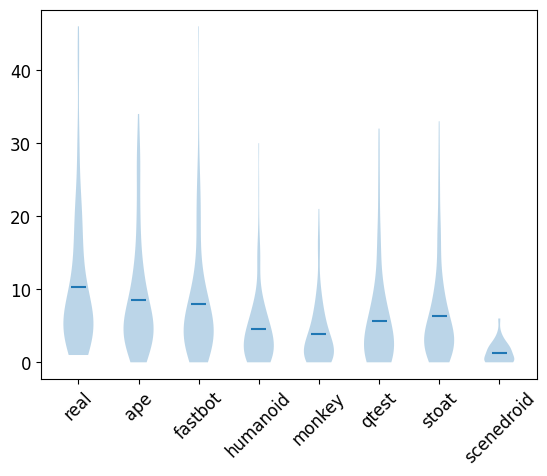

Statistical test
real vs fastbot 0.027570456657198178 0.19720588235294118
real vs humanoid 1.9618119176439946e-08 0.49751948972360027
real vs monkey 1.2606908822523322e-10 0.5722182849043231
real vs qtest 1.086346007410264e-05 0.3915351506456241
real vs stoat 8.100287368667522e-05 0.35192447349310096
real vs scenedroid 1.7237882199225908e-13 0.9019607843137255
ape vs humanoid 1.2912779794462342e-05 0.3902439024390244
ape vs monkey 1.962267679507762e-07 0.4670878636497208
ape vs qtest 0.0012204552062696308 0.2907495538370018
ape vs stoat 0.009015452315925265 0.23562180066245106
ape vs scenedroid 3.729912997615097e-11 0.8138211382113821
fastbot vs real 0.027570456657198178 -0.19720588235294118
fastbot vs humanoid 0.00036745760933579234 0.32033132530120484
fastbot vs monkey 6.560105794228666e-06 0.4069277108433735
fastbot vs qtest 0.013118561949059358 0.22423780487804879
fastbot vs scenedroid 3.118671117327504e-10 0.77625
humanoid vs real 1.9618119176439946e-08 -0.49751948972360027
humano

In [21]:
violin_plot(all_tool_size, "size_violin_plot.pdf", log_scale=False, show_prop=False)
statistic_test(all_tool_size, [])
statistic_values(all_tool_size)

Plotting violin plot


<Figure size 800x1000 with 0 Axes>

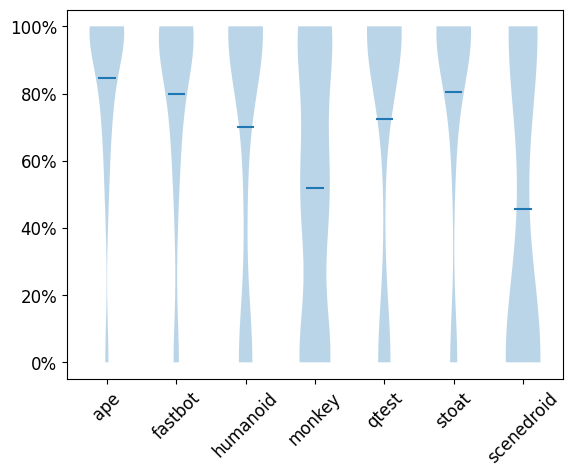

Statistical test
ape vs monkey 6.274709919038925e-08 0.4675286511901264
ape vs scenedroid 0.001323147112120327 0.366260162601626
fastbot vs monkey 7.516331958036602e-06 0.39292168674698796
fastbot vs scenedroid 0.007794880827784281 0.31125
humanoid vs monkey 0.0011956446021230344 0.27667295688779214
humanoid vs scenedroid 0.02782083267411052 0.2461847389558233
monkey vs ape 6.274709919038925e-08 -0.4675286511901264
monkey vs fastbot 7.516331958036602e-06 -0.39292168674698796
monkey vs humanoid 0.0011956446021230344 -0.27667295688779214
monkey vs qtest 0.00032293556301482844 -0.3073758448427858
monkey vs stoat 8.576981370082074e-07 -0.42094303138479844
qtest vs monkey 0.00032293556301482844 0.3073758448427858
qtest vs scenedroid 0.01895812878151978 0.2613821138211382
stoat vs monkey 8.576981370082074e-07 0.42094303138479844
stoat vs scenedroid 0.0019105392683345782 0.3432098765432099
scenedroid vs ape 0.001323147112120327 -0.366260162601626
scenedroid vs fastbot 0.007794880827784281 -0.

In [15]:
violin_plot(all_precision_scores, "precision_violin_plot.pdf", log_scale=False, show_prop=True)
statistic_test(all_precision_scores, [])
statistic_values(all_precision_scores)

Plotting violin plot


<Figure size 800x1000 with 0 Axes>

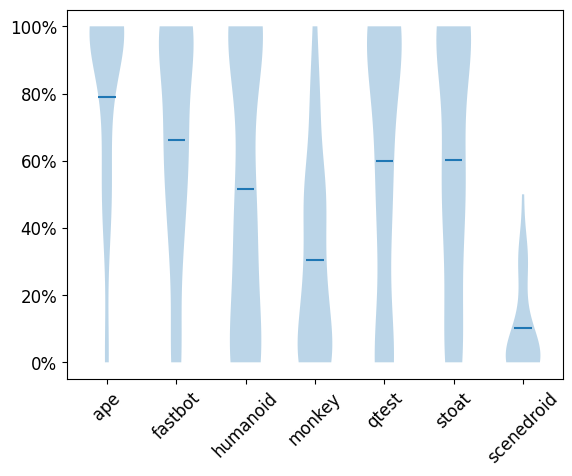

Statistical test
ape vs fastbot 0.005085130131572609 0.24527439024390243
ape vs humanoid 2.5233431312856254e-05 0.3649720834557743
ape vs monkey 4.709515199221465e-16 0.7212753452835733
ape vs qtest 0.0017928398114222528 0.27022605591909576
ape vs stoat 0.001053526354790808 0.2850045167118338
ape vs scenedroid 1.0268638834682956e-13 0.8914634146341464
fastbot vs ape 0.005085130131572609 -0.24527439024390243
fastbot vs humanoid 0.03774660530193143 0.18509036144578314
fastbot vs monkey 4.077476074850494e-10 0.5629518072289157
fastbot vs scenedroid 4.169885200563201e-11 0.8104166666666667
humanoid vs ape 2.5233431312856254e-05 -0.3649720834557743
humanoid vs fastbot 0.03774660530193143 -0.18509036144578314
humanoid vs monkey 0.0019875664563760043 0.2742052547539556
humanoid vs scenedroid 7.442468797486207e-06 0.5413654618473895
monkey vs ape 4.709515199221465e-16 -0.7212753452835733
monkey vs fastbot 4.077476074850494e-10 -0.5629518072289157
monkey vs humanoid 0.0019875664563760043 -0.274

In [16]:
violin_plot(all_recall_scores, "recall_violin_plot.pdf", log_scale=False, show_prop=True)
statistic_test(all_recall_scores, [])
statistic_values(all_recall_scores)

Plotting violin plot


<Figure size 800x1000 with 0 Axes>

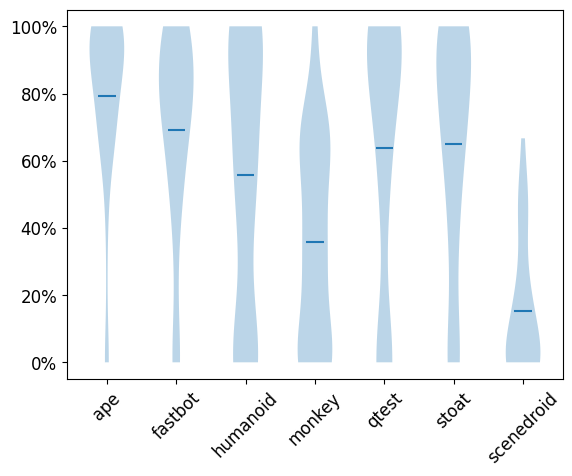

Statistical test
ape vs fastbot 0.012115034293099665 0.22591463414634147
ape vs humanoid 0.0004228436393930627 0.31281222450778723
ape vs monkey 2.2008172731285407e-16 0.7355274757566853
ape vs stoat 0.009182877459650985 0.23336344474555856
ape vs scenedroid 4.201122683702911e-13 0.8882113821138211
fastbot vs ape 0.012115034293099665 -0.22591463414634147
fastbot vs monkey 7.440419044614954e-11 0.5876506024096385
fastbot vs scenedroid 5.985204092980257e-11 0.8070833333333334
humanoid vs ape 0.0004228436393930627 -0.31281222450778723
humanoid vs monkey 0.0005552318824610282 0.30657570039192916
humanoid vs scenedroid 8.2525506102939e-06 0.5397590361445783
monkey vs ape 2.2008172731285407e-16 -0.7355274757566853
monkey vs fastbot 7.440419044614954e-11 -0.5876506024096385
monkey vs humanoid 0.0005552318824610282 -0.30657570039192916
monkey vs qtest 6.352960415362448e-07 -0.4434322656479577
monkey vs stoat 5.107713922094316e-08 -0.4890673806336457
monkey vs scenedroid 0.0016876677679685459 0

In [19]:
violin_plot(all_f1_scores, "f1_violin_plot.pdf", log_scale=False, show_prop=True)
statistic_test(all_f1_scores, [])
statistic_values(all_f1_scores)